# Building RNN network from Scratch in Python

- Input: A sequence of numbers
- Output: Single scalar => Next value in the sequence
- Approach Credits: https://pythonalgos.com/build-a-recurrent-neural-network-from-scratch-in-python-3/


In [35]:
import math
from matplotlib import pyplot as plt
import numpy as np
import random

def get_sin_wave(noise = 0.05, points = 500):
    
    sin_wave = []
    c = 0.01
    for i in range(points):
        n = random.random()*noise
        sin_wave.append(c*i+math.sin(i*0.5+n))
    
    sin_wave = np.array(sin_wave)
    
    return sin_wave

In [36]:
seq_len = 10

def get_Data(sin_wave):
    X = []
    Y = []
    num_records = len(sin_wave) - seq_len

    for i in range(num_records):
        X.append(sin_wave[i:i+seq_len])
        Y.append(sin_wave[i+seq_len])

    X = np.array(X)
    X = np.expand_dims(X, axis=2)

    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=1)
    
    return X,Y


# Data preparation

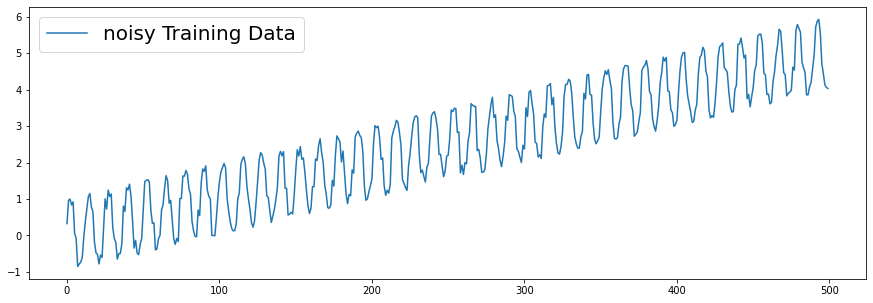

(490, 10, 1) (490, 1)


In [37]:
# Training Data

sin_wave = get_sin_wave(noise=1.0)
plt.figure(figsize=(15, 5))
plt.plot(sin_wave, label='noisy Training Data')
plt.legend(fontsize=20)
plt.show()

X,Y = get_Data(sin_wave)
print(X.shape, Y.shape)

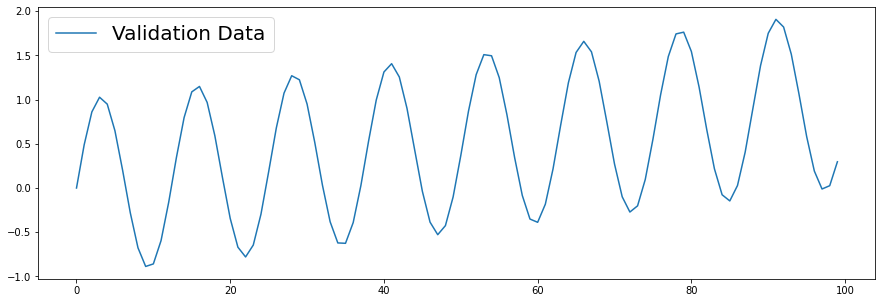

(90, 10, 1) (90, 10, 1)


In [38]:
# Validation Data

sin_wave_val= get_sin_wave(noise=0.0,points = 100)

plt.figure(figsize=(15, 5))
plt.plot(sin_wave_val, label='Validation Data')
plt.legend(fontsize=20)
plt.show()

# Training Data
X_val,Y_val = get_Data(sin_wave_val)
print(X_val.shape, X_val.shape)

# Now creating an RNN model
- Model takes in the input sequence, process it through a hidden layer of 100 units, and produce a single output

In [106]:
# create RNN architecture
learning_rate = 0.0001
#seq_len = 50
max_epochs = 500
hidden_dim = 100
output_dim = 1
bptt_truncate = 5 # backprop through time --> lasts 5 iterations
min_clip_val = -5
max_clip_val = 5

In [40]:
U = np.random.uniform(0, 1, (hidden_dim,seq_len))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))
print(U.shape, W.shape, V.shape)

(100, 10) (100, 100) (1, 100)


In [41]:
# Activation of hidden layer
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Train the Model
## Check loss on training data
- Forward pass
- calculate error

## Check loss of validation data
- Forward pass
- Calculate error

## Training
- Forward pass
- Back-propagation
- Update weights

In [42]:
def calculate_loss(X, Y, U, V, W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_activation = np.zeros((hidden_dim, 1)) # value of previous activation
        for timestep in range(seq_len):
            new_input = np.zeros(x.shape) # forward pass, done for each step in the sequence
            new_input[timestep] = x[timestep] # define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_activation)
            _sum = mulu + mulw
            activation = sigmoid(_sum)
            mulv = np.dot(V, activation)
            prev_activation = activation
        # calculate and add loss per record
        loss_per_record = float((y - mulv)**2/2)
        loss += loss_per_record
    # calculate loss after first Y pass
    return loss, activation

In [43]:
# takes x values and the weights matrices
# returns layer dictionary, final weights (mulu, mulw, mulv)
def calc_layers(x, U, V, W, prev_activation):
    layers = []
    for timestep in range(seq_len):
        new_input = np.zeros(x.shape)
        new_input[timestep] = x[timestep]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_activation)
        _sum = mulw + mulu
        activation = sigmoid(_sum)
        mulv = np.dot(V, activation)
        layers.append({'activation': activation, 'prev_activation': prev_activation})
        prev_activation = activation
 
    return layers, mulu, mulw, mulv
                
                 
def backprop(x, U, V, W, dmulv, mulu, mulw, layers):
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
   
    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)
   
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
   
    _sum = mulu + mulw
    dsv = np.dot(np.transpose(V), dmulv)
   
    def get_previous_activation_differential(_sum, ds, W):
        d_sum = _sum * (1 - _sum) * ds
        dmulw = d_sum * np.ones_like(ds)
        return np.dot(np.transpose(W), dmulw)
   
    for timestep in range(seq_len):
        dV_t = np.dot(dmulv, np.transpose(layers[timestep]['activation']))
        ds = dsv
        dprev_activation = get_previous_activation_differential(_sum, ds, W)
       
        for _ in range(timestep-1, max(-1, timestep-bptt_truncate-1), -1):
            ds = dsv + dprev_activation
            dprev_activation = get_previous_activation_differential(_sum, ds, W)
            dW_i = np.dot(W, layers[timestep]['prev_activation'])
           
            new_input = np.zeros(x.shape)
            new_input[timestep] = x[timestep]
            dU_i = np.dot(U, new_input)
           
            dU_t += dU_i
            dW_t += dW_i
           
        dU += dU_t
        dV += dV_t
        dW += dW_t
       
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
       
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
       
    return dU, dV, dW

In [44]:
# training
def train(U, V, W, X, Y, X_validation, Y_validation):
    for epoch in range(max_epochs):
        # calculate initial loss, ie what the output is given a random set of weights
        loss, prev_activation = calculate_loss(X, Y, U, V, W)
 
        # check validation loss
        val_loss, _ = calculate_loss(X_validation, Y_validation, U, V, W)
       
        print(f'Epoch: {epoch+1}, Loss: {loss}, Validation Loss: {val_loss}')
 
        # train model/forward pass
        for i in range(Y.shape[0]):
            x, y = X[i], Y[i]
            layers = []
            prev_activation = np.zeros((hidden_dim, 1))
           
            layers, mulu, mulw, mulv = calc_layers(x, U, V, W, prev_activation)
               
            # difference of the prediction
            dmulv = mulv - y
            dU, dV, dW = backprop(x, U, V, W, dmulv, mulu, mulw, layers)
           
            # update weights
            U -= learning_rate * dU
            V -= learning_rate * dV
            W -= learning_rate * dW
    return U, V, W

In [107]:
U, V, W = train(U, V, W, X, Y, X_val, Y_val)

Epoch: 1, Loss: 63.83036096099715, Validation Loss: 8.826685927936637
Epoch: 2, Loss: 63.83088842111263, Validation Loss: 8.83471474747469
Epoch: 3, Loss: 63.83139047423241, Validation Loss: 8.842756426982698
Epoch: 4, Loss: 63.83187039353145, Validation Loss: 8.850812286527292
Epoch: 5, Loss: 63.832328214275606, Validation Loss: 8.858881593546272
Epoch: 6, Loss: 63.83276508588971, Validation Loss: 8.866964667247693
Epoch: 7, Loss: 63.83317966712481, Validation Loss: 8.875061542130517
Epoch: 8, Loss: 63.833561945954465, Validation Loss: 8.883168306840405
Epoch: 9, Loss: 63.833902912869085, Validation Loss: 8.8912807933353
Epoch: 10, Loss: 63.834198602376574, Validation Loss: 8.899397145124095
Epoch: 11, Loss: 63.8344414316303, Validation Loss: 8.90751436181856
Epoch: 12, Loss: 63.834628375590405, Validation Loss: 8.91563092709085
Epoch: 13, Loss: 63.834762451821, Validation Loss: 8.92374785514446
Epoch: 14, Loss: 63.834846704553804, Validation Loss: 8.931866262086237
Epoch: 15, Loss: 6

Epoch: 117, Loss: 63.89475508557823, Validation Loss: 9.887810444531903
Epoch: 118, Loss: 63.89599864433499, Validation Loss: 9.898087414290236
Epoch: 119, Loss: 63.89723434769768, Validation Loss: 9.908368771372615
Epoch: 120, Loss: 63.89846356851202, Validation Loss: 9.918654970878055
Epoch: 121, Loss: 63.899687019874996, Validation Loss: 9.928946299439263
Epoch: 122, Loss: 63.90090201527155, Validation Loss: 9.939241970512603
Epoch: 123, Loss: 63.90210844160365, Validation Loss: 9.949541317627626
Epoch: 124, Loss: 63.90330298265879, Validation Loss: 9.959842579633165
Epoch: 125, Loss: 63.90448489252336, Validation Loss: 9.97014527764763
Epoch: 126, Loss: 63.90565104334281, Validation Loss: 9.98044793072705
Epoch: 127, Loss: 63.9067994902659, Validation Loss: 9.99074984093004
Epoch: 128, Loss: 63.907933245061834, Validation Loss: 10.001052218497879
Epoch: 129, Loss: 63.909059679720826, Validation Loss: 10.011358272272117
Epoch: 130, Loss: 63.91017972255519, Validation Loss: 10.021668

Epoch: 230, Loss: 63.996877020423966, Validation Loss: 11.06251697666175
Epoch: 231, Loss: 63.9968778271315, Validation Loss: 11.07258140893103
Epoch: 232, Loss: 63.99685388287505, Validation Loss: 11.082633369655074
Epoch: 233, Loss: 63.99680801341879, Validation Loss: 11.092674224541774
Epoch: 234, Loss: 63.99674330161472, Validation Loss: 11.10270553125533
Epoch: 235, Loss: 63.996657753831094, Validation Loss: 11.112726629187351
Epoch: 236, Loss: 63.99655028637694, Validation Loss: 11.122737159998277
Epoch: 237, Loss: 63.99642330258886, Validation Loss: 11.132737931401474
Epoch: 238, Loss: 63.996276862707845, Validation Loss: 11.142728691153872
Epoch: 239, Loss: 63.99611116556342, Validation Loss: 11.152709481781736
Epoch: 240, Loss: 63.995926414652565, Validation Loss: 11.162680347005807
Epoch: 241, Loss: 63.99572051201012, Validation Loss: 11.172640809249938
Epoch: 242, Loss: 63.9954956561971, Validation Loss: 11.182591554050507
Epoch: 243, Loss: 63.995248953674995, Validation Los

Epoch: 343, Loss: 63.9051050683, Validation Loss: 12.144874422399637
Epoch: 344, Loss: 63.903750361056254, Validation Loss: 12.154007206287169
Epoch: 345, Loss: 63.90238580985438, Validation Loss: 12.163130650726723
Epoch: 346, Loss: 63.90101142929383, Validation Loss: 12.17224473416893
Epoch: 347, Loss: 63.89962723335124, Validation Loss: 12.181349434890176
Epoch: 348, Loss: 63.89823323538649, Validation Loss: 12.190444730995347
Epoch: 349, Loss: 63.89682944815495, Validation Loss: 12.199530600422127
Epoch: 350, Loss: 63.89541588381592, Validation Loss: 12.208607020944406
Epoch: 351, Loss: 63.89399255394459, Validation Loss: 12.21767397017672
Epoch: 352, Loss: 63.89256023696363, Validation Loss: 12.22673186525713
Epoch: 353, Loss: 63.89111957134213, Validation Loss: 12.235781046499854
Epoch: 354, Loss: 63.889670178776875, Validation Loss: 12.244821492045666
Epoch: 355, Loss: 63.88821169905832, Validation Loss: 12.253853347885267
Epoch: 356, Loss: 63.88674446225814, Validation Loss: 12

Epoch: 456, Loss: 63.63856541725565, Validation Loss: 13.0785411298717
Epoch: 457, Loss: 63.634719950146845, Validation Loss: 13.085590410225608
Epoch: 458, Loss: 63.63084113044775, Validation Loss: 13.092614227477092
Epoch: 459, Loss: 63.62692293585374, Validation Loss: 13.09960940789184
Epoch: 460, Loss: 63.62296293398526, Validation Loss: 13.106574173402427
Epoch: 461, Loss: 63.618961609247556, Validation Loss: 13.113508757516703
Epoch: 462, Loss: 63.6149160887426, Validation Loss: 13.120411518067701
Epoch: 463, Loss: 63.610822482488345, Validation Loss: 13.12728020988684
Epoch: 464, Loss: 63.60667739482707, Validation Loss: 13.134112619817513
Epoch: 465, Loss: 63.60248170850642, Validation Loss: 13.140909222980595
Epoch: 466, Loss: 63.59823631931434, Validation Loss: 13.14767043769753
Epoch: 467, Loss: 63.59394049363587, Validation Loss: 13.154396088309676
Epoch: 468, Loss: 63.589596293561144, Validation Loss: 13.161086949217278
Epoch: 469, Loss: 63.58520432481683, Validation Loss:

# Get predictions

In [102]:
def get_predictions(X, T):
    global U, V, W
    preds = []
    for i in range(X.shape[0]):
        x = X[i]
        prev_s = np.zeros((hidden_dim, 1))
        # Forward pass
        for t in range(T):
            mulu = np.dot(U, x)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
            
        preds.append(mulv)

    preds = np.array(preds)
    return preds

In [103]:
y_pred = get_predictions(X,seq_len)
print(y_pred.shape)

(490, 1, 1)


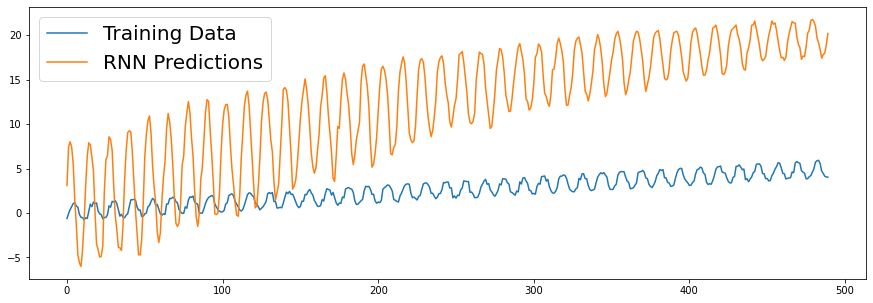

In [104]:
plt.figure(figsize=(15, 5))
plt.plot(Y[:,0], label='Training Data')
plt.plot(y_pred[:,0,0], label='RNN Predictions')
plt.legend(fontsize=20)
plt.show()

# Using GRU cell from Keras

In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [50]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(X.shape[1], X.shape[2])))
model.add(tf.keras.layers.GRU(16, activation='relu'))
model.add(tf.keras.layers.Dense(Y.shape[1]))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.fit(X[:350], Y[:350], batch_size=64, epochs=100,
            verbose=1)

Epoch 1/100
350/350 [==============================] - 0s 1ms/sample - loss: 6.4036
Epoch 2/100
350/350 [==============================] - 0s 115us/sample - loss: 6.2115
Epoch 3/100
350/350 [==============================] - 0s 103us/sample - loss: 5.9998
Epoch 4/100
350/350 [==============================] - 0s 109us/sample - loss: 5.7746
Epoch 5/100
350/350 [==============================] - 0s 101us/sample - loss: 5.5461
Epoch 6/100
350/350 [==============================] - 0s 100us/sample - loss: 5.3209
Epoch 7/100
350/350 [==============================] - 0s 99us/sample - loss: 5.1049
Epoch 8/100
350/350 [==============================] - 0s 97us/sample - loss: 4.8927
Epoch 9/100
350/350 [==============================] - 0s 101us/sample - loss: 4.6838
Epoch 10/100
350/350 [==============================] - 0s 103us/sample - loss: 4.4867
Epoch 11/100
350/350 [==============================] - 0s 106us/sample - loss: 4.2779
Epoch 12/100
350/350 [==============================] - 

350/350 [==============================] - 0s 107us/sample - loss: 0.0744
Epoch 96/100
350/350 [==============================] - 0s 111us/sample - loss: 0.0742
Epoch 97/100
350/350 [==============================] - 0s 114us/sample - loss: 0.0737
Epoch 98/100
350/350 [==============================] - 0s 114us/sample - loss: 0.0760
Epoch 99/100
350/350 [==============================] - 0s 112us/sample - loss: 0.0758
Epoch 100/100
350/350 [==============================] - 0s 110us/sample - loss: 0.0751


In [52]:
y_pred = model.predict(X)

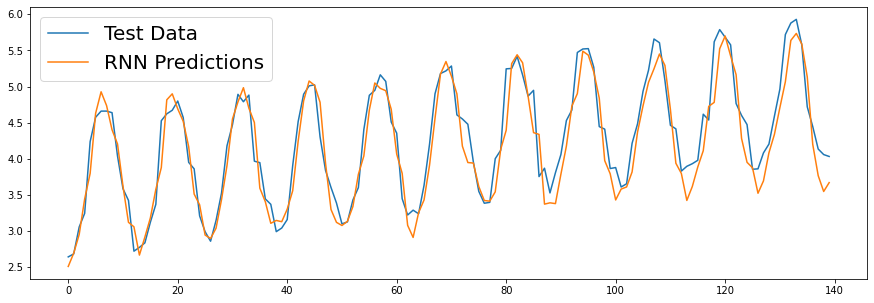

In [53]:
plt.figure(figsize=(15, 5))
plt.plot(Y[350:,0], label='Test Data')
plt.plot(y_pred[350:,0], label='RNN Predictions')
plt.legend(fontsize=20)
plt.show()